In [4]:
import math as mt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [176]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0.0
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other=other if isinstance(other, Value) else Value(other)
        out=Value(self.data+other.data, (self, other), "+")

        def _backward():
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other=other if isinstance(other, Value) else Value(other)
        out=Value(self.data*other.data, (self, other), "*")

        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self*other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        other=other if isinstance(other, Value) else Value(other)
        return self + (-other)
    
    def tanh(self):
        x=self.data
        t=(mt.exp(2*x) - 1)/(mt.exp(2*x)+1)
        out=Value(t, (self, ), "tanh")

        def _backward():
            self.grad=+(1-t**2)*out.grad
        out._backward=_backward

        return out
    
    def exp(self):
        x=self.data
        out=Value(mt.exp(x), (self, ), "exp")

        def _backward():
            self.grad+=out.data*out.grad
        out._backward=_backward

        return out
    
    def backward(self):
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad=1.0
        for node in reversed(topo):
            node._backward()

In [177]:
a=Value(6.0)
b=Value(3.0)
b-2

Value(data=1.0)

In [73]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label,n.data, n.grad), shape="record")
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

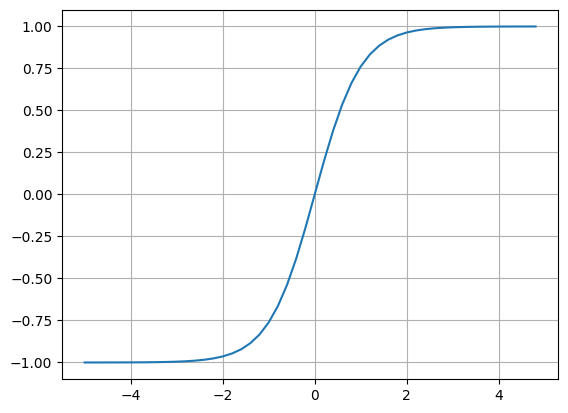

In [98]:
plt.plot(np.arange(-5, 5, .2), np.tanh(np.arange(-5, 5, .2))); plt.grid()

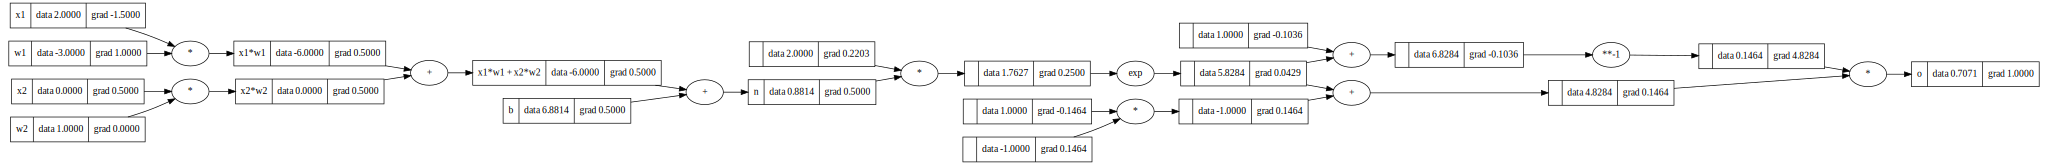

In [179]:
#inputs
x1=Value(2.0, label="x1")
x2=Value(0.0, label="x2")
#weights
w1=Value(-3.0, label="w1")
w2=Value(1.0, label="w2")
#bias
b=Value(6.8813735870195432, label="b")
#x1*w1+x2*w2+b
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label="n"
e=(2*n).exp()
o=(e-1)/(e+1)
o.label="o"
o.backward()
draw_dot(o)